In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [88]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import os
import datetime as dt
from statistics import mean

In [47]:
#output file path for data resource files and figures
outputFilePath = os.path.join("output-data")

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()
#tables in hawaii.sqlite database

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
print(f"measurement table reference: {Measurement}\nstation table reference: {Station}")

measurement table reference: <class 'sqlalchemy.ext.automap.measurement'>
station table reference: <class 'sqlalchemy.ext.automap.station'>


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Explore the Data
Find out more about the headers and information

In [10]:
conn = engine.connect()

In [11]:
measurement_df = pd.read_sql("select * from measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [12]:
measurement_df.dtypes

id           int64
station     object
date        object
prcp       float64
tobs       float64
dtype: object

In [13]:
station_df = pd.read_sql("select * from station", conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [14]:
station_df.dtypes

id             int64
station       object
name          object
latitude     float64
longitude    float64
elevation    float64
dtype: object

# Exploratory Climate Analysis

In [15]:
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
latestDate = list(np.ravel(latestDate))[0]
latestDate

'2017-08-23'

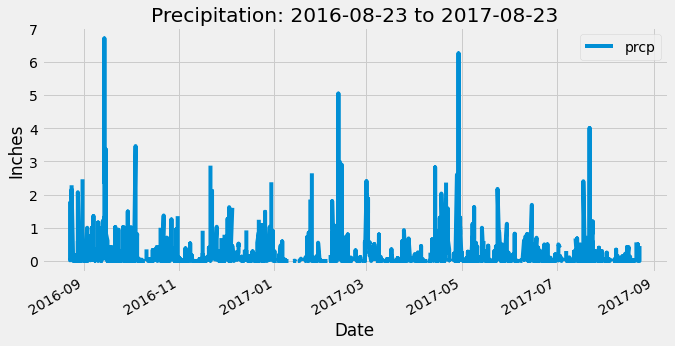

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#find the last date in the database
endDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# endDate (yyyy-mm-dd) = 2017-08-23
endDate = list(np.ravel(endDate))[0]

# Calculate the date 1 year ago from the last data point in the database
startDate = dt.date.fromisoformat(endDate)-pd.DateOffset(years=1)
startDate = startDate.strftime('%Y-%m-%d')
# check the dates
# print(f"{startDate} to {endDate}")

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp)\
                        .filter(and_(Measurement.date>=startDate, Measurement.date<=endDate))\
                        .all()
# prcp_scores

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_scores)

# Sort the dataframe by date
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df = prcp_df.sort_values(by='date')
# prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
chartTitle = f"Precipitation: {startDate} to {endDate}"
# set the index to the date
prcp_chartData = prcp_df.set_index('date') 

#plot
prcp_fig = prcp_chartData.plot(title=chartTitle, figsize=(10,5))
prcp_fig.set_xlabel("Date")
prcp_fig.set_ylabel("Inches")

#save figure
fig = prcp_fig.get_figure()
fig.savefig(os.path.join(outputFilePath,"Percipitation-Chart.png"))

In [33]:
# plt.bar(prcp_df['date'],prcp_df['prcp'])
# plt.xlabel("Date")
# plt.ylabel("Inches")
# plt.title(chartTitle)
# plt.xticks(rotation='vertical')
# plt.tight_layout()

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_chartData.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [51]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(Station).count()
print(f"There are {stationCount} stations available in the dataset.")

There are 9 stations available in the dataset.


In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCount_List = session.query(Measurement.station, func.count(Measurement.station)) \
            .group_by(Measurement.station) \
            .order_by(func.count(Measurement.station).desc()) \
            .all()
stationCount_List

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [100]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
activeStation_ID = stationCount_List[0][0]
activeStation_Name = session.query(Station.name).filter_by(station=activeStation_ID)
activeStation_Name = activeStation_Name[0][0]

activeStation_Temp = session.query(Measurement.tobs).filter_by(station=activeStation_ID).all()
activeStation_Temp = list(map(lambda x: x[0], activeStation_Temp))
activeStation_minTemp = min(activeStation_Temp)
activeStation_maxTemp = max(activeStation_Temp)
activeStation_avgTemp = mean(activeStation_Temp)
print(f"Most Active\nStation: {activeStation_Name}\nStation ID: {activeStation_ID}")
print(f"Average Temperature: {'{:,.2f}'.format(activeStation_avgTemp)} F deg")
print(f"Max Temperature: {'{:,.2f}'.format(activeStation_maxTemp)} F deg")
print(f"Min Temperature: {'{:,.2f}'.format(activeStation_minTemp)} F deg")

Most Active
Station: WAIHEE 837.5, HI US
Station ID: USC00519281
Average Temperature: 71.66 F deg
Max Temperature: 85.00 F deg
Min Temperature: 54.00 F deg


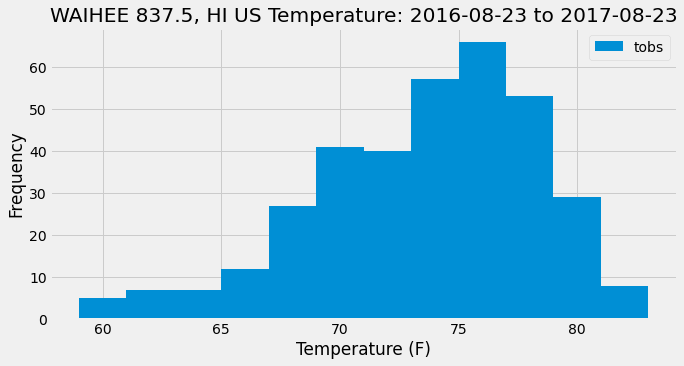

In [118]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activeStation_tempDates = session.query(Measurement.date, Measurement.tobs)\
                                .filter(Measurement.station==activeStation_ID)\
                                .filter(and_(Measurement.date>=startDate, Measurement.date<=endDate))\
                                .all()
activeStation_tempDates_df = pd.DataFrame(activeStation_tempDates)

# Sort the dataframe by date
activeStation_tempDates_df['date'] = pd.to_datetime(activeStation_tempDates_df['date'])
activeStation_tempDates_df = activeStation_tempDates_df.sort_values(by='date')
# prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
chartTitle_hist = f"{activeStation_Name} Temperature: {startDate} to {endDate}"
# set the index to the date
activeStation_tempDates_chartData = activeStation_tempDates_df.set_index('date')

#plot
aS_tD_fig = activeStation_tempDates_chartData.plot.hist(bins=12,title=chartTitle_hist, figsize=(10,5))
aS_tD_fig.set_xlabel("Temperature (F)")
aS_tD_fig.set_ylabel("Frequency")

#save figure
fig = aS_tD_fig.get_figure()
fig.savefig(os.path.join(outputFilePath,"ActiveStation-Temp-Chart.png"))

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
